# Load and preprocess images
 - How to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as tf.keras.utils.image_dataset_from_directory) and layers (such as tf.keras.layers.Rescaling) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch using tf.data.
- Finally, you will download a dataset from the large catalog available in TensorFlow Datasets.

In [3]:
pip install tensorflow_datasets

  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=b8f69e0060718ffdd1611a116003585776a3c46cb60f01b3c36ab8e70de0106e
  Stored in directory: c:\users\khim\appdata\local\pip\cache\wheels\e1\e8\83\ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Setup
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.8.0


__Download the flowers dataset__
- The flowers dataset contains five sub-directories, one per class:
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 5s 0us/step


After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

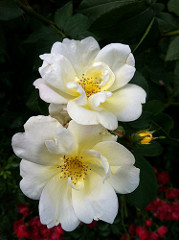

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

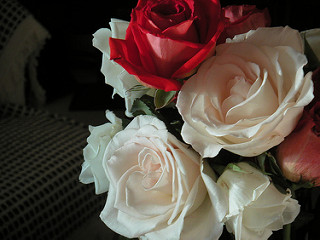

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

__Load data using a Keras utility__
- Let's load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.

Create a dataset
- Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. I will use 80% of the images for training and 20% for validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


__Visualize the data__
- Here are the first nine images from the training dataset.

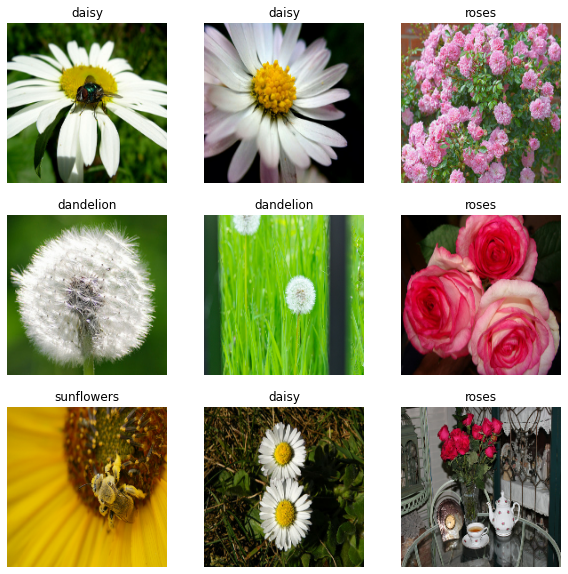

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [38]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

__Standardize the data__
- The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

- Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [39]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9994554


Or, we can include the layer inside your model definition to simplify deployment. We will use the second approach here.

__Note:__ If you would like to scale pixel values to [-1,1] you can instead write tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking.
- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [42]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build a model

In [43]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

__Compile model__

In [44]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

__Train model__

In [46]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 27s 297ms/step - loss: 0.7354 - accuracy: 0.7228 - val_loss: 0.8735 - val_accuracy: 0.6635
Epoch 2/10
92/92 [==============================] - 28s 306ms/step - loss: 0.5498 - accuracy: 0.7970 - val_loss: 0.9544 - val_accuracy: 0.6703
Epoch 3/10
92/92 [==============================] - 28s 308ms/step - loss: 0.3928 - accuracy: 0.8614 - val_loss: 1.1948 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 29s 314ms/step - loss: 0.3484 - accuracy: 0.8781 - val_loss: 1.4061 - val_accuracy: 0.6158
Epoch 5/10
92/92 [==============================] - 29s 313ms/step - loss: 0.3010 - accuracy: 0.8934 - val_loss: 1.3883 - val_accuracy: 0.5995
Epoch 6/10
92/92 [==============================] - 28s 306ms/step - loss: 0.1725 - accuracy: 0.9428 - val_loss: 1.4079 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 28s 310ms/step - loss: 0.0926 - accuracy: 0.9755 - val_loss: 1.7863 - val_accuracy: 0.6172

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting.

# Using tf.data for finer control

The above Keras preprocessing utility—tf.keras.utils.image_dataset_from_directory—is a convenient way to create a tf.data.Dataset from a directory of images.
- For finer grain control, you can write your own input pipeline using tf.data.

In [47]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [52]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\KHIM\\.keras\\datasets\\flower_photos\\daisy\\7377004908_5bc0cde347_n.jpg'
b'C:\\Users\\KHIM\\.keras\\datasets\\flower_photos\\tulips\\3498663243_42b39b4185_m.jpg'
b'C:\\Users\\KHIM\\.keras\\datasets\\flower_photos\\dandelion\\8684925862_d736e153bf_n.jpg'
b'C:\\Users\\KHIM\\.keras\\datasets\\flower_photos\\roses\\8742493689_fb852f0228_n.jpg'
b'C:\\Users\\KHIM\\.keras\\datasets\\flower_photos\\tulips\\16062072523_1be3c0b61f.jpg'


In [54]:
#The tree structure of the files can be used to compile a class_names list.
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [55]:
#Split the dataset into training and validation sets:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [56]:
#You can print the length of each dataset as follows:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


__Write a short function that converts a file path to an (img, label) pair:__

In [57]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [58]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [59]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

__Use Dataset.map to create a dataset of image, label pairs:__

In [60]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [67]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  4
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  4


__Configure dataset for performance__
To train a model with this dataset you will want the data:
- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible:
  These features can be added using the tf.data API

In [69]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

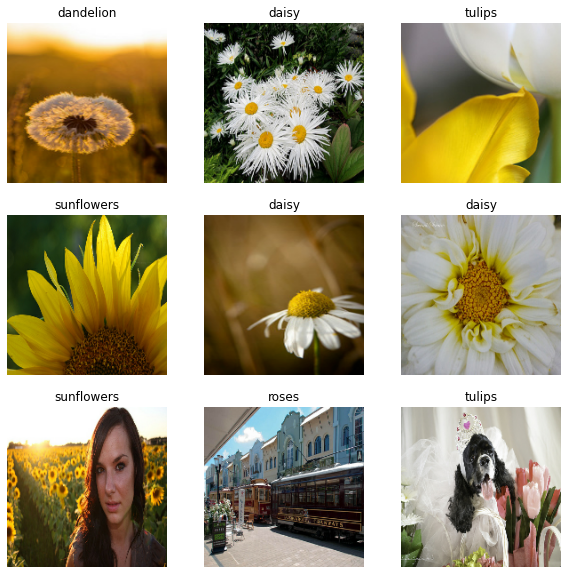

In [72]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

__Continue training the model__
- We have now manually built a similar tf.data.Dataset to the one created by tf.keras.utils.image_dataset_from_directory above. We can continue training the model with it.

In [73]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 33s 351ms/step - loss: 0.4308 - accuracy: 0.8900 - val_loss: 0.4372 - val_accuracy: 0.8828
Epoch 2/3
92/92 [==============================] - 35s 382ms/step - loss: 0.1378 - accuracy: 0.9615 - val_loss: 0.4817 - val_accuracy: 0.8965
Epoch 3/3
92/92 [==============================] - 35s 381ms/step - loss: 0.0452 - accuracy: 0.9891 - val_loss: 0.5447 - val_accuracy: 0.8951


# Using TensorFlow Datasets

As you have previously loaded the Flowers dataset off disk, let's now import it with TensorFlow Datasets.

In [74]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\tf_flowers\3.0.1.incompleteRG5X64\tf_flowers-train.tfrecord*...:   0%|        …

Dataset tf_flowers downloaded and prepared to ~\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes:

In [75]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


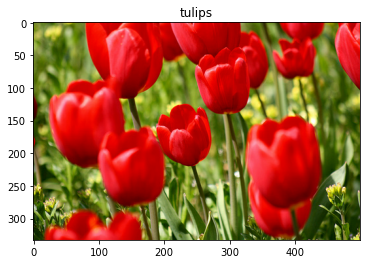

In [76]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [77]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)